<h2> Construction des Modèles de Deep Learning sur les Données de l'Herbier </h2>

In [42]:
%matplotlib inline
import os
import zipfile
from pathlib import Path
import re
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
tf.config.list_physical_devices('GPU')

---

In [2]:
relativeProjectPath = Path.cwd().parent
dataPath = relativeProjectPath / 'Data'


---

#### Feature Engineering 

##### Load the Initial **Datasets** of Images based on the Herbarium

In [3]:
# Function that verify a Path and its content
def verifyFolderPathContent(initPath, labelPath='',):
    if not (os.path.exists(initPath)):  # Verify whether the current path exists or not 
        return print(f'{labelPath} Path -> Not Validated (Path does not Exists) \nVeriy the path or Reexecute the file: "InitializationDataHerbarium.ipynb"')
    if not os.listdir(initPath): # Verify whether the current path has empty content or not 
        return print(f'{labelPath} Path -> Not Validated (Path Exists BUT Path Content is Empty) \nVeriy the path or Reexecute the file: "InitializationDataHerbarium.ipynb"')
    return print(f'{labelPath} Path -> Validated (Path Exists AND Path Content is not Empty)')

In [4]:
initDatasetPath = dataPath / 'Dataset'
verifyFolderPathContent(initDatasetPath, 'Dataset')

Dataset Path -> Validated (Path Exists AND Path Content is not Empty)


##### Transform the IMAGES from both the **Train** and **Test** Initial Dataset

In [5]:
# Function that transform a 3D-Image into a 2D-Image
def grayscaleImage(Image):
    dcopyImage = np.zeros(Image.shape[:2])
    for row in range(dcopyImage.shape[0]):
        for col in range(dcopyImage.shape[1]):
            dcopyImage[row][col] = (sum(Image[row, col] * 1/3))
    return dcopyImage

In [6]:
def makeImageTransformation(imagePath, prevFolderName='Dataset', uptFolderName='Transformed_Dataset', imageSize = 512):
    
    
    # Step ~0: Read the Image
    Image = cv2.imread(imagePath)
    # grayImage = grayscaleImage(Image)

    # Step ~1: Resize the Image
    resizedImage = cv2.resize(Image, (imageSize, imageSize), interpolation=cv2.INTER_AREA)
    
    
    # _, thresh = cv2.threshold(grayImage, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # # Apply mask to colored_image
    # colored_image = cv2.bitwise_or(colored_image, colored_image, mask=cv2.bitwise_not(thresh))
    
    # Step ~X: Save the Transformed Image following a similar Path (except for the main directory name)
    newImagePath = imagePath.__str__().replace(prevFolderName, uptFolderName)
    Path(newImagePath).parent.mkdir(parents=True, exist_ok=True)  # Verify whether the Folder exists and Create it
    cv2.imwrite(newImagePath, resizedImage)
    
    pass

In [7]:
transformFolder = 'Transformed_Dataset'
imageSize = 512

# Loop through each FILE and apply an IMAGE transformation
for dir_, _, files in os.walk(initDatasetPath):
    for file_name in files:
      imagePath = (initDatasetPath / dir_ / file_name).__str__()
      makeImageTransformation(imagePath, prevFolderName=initDatasetPath.name, uptFolderName=transformFolder, imageSize = imageSize)

##### Load the Transformed **Train** and **Test** Datasets Images based on the Herbarium

In [8]:
modifDatasetPath = dataPath / 'Transformed_Dataset'
trainPath = modifDatasetPath / 'Train'
testPath = modifDatasetPath / 'Test'
verifyFolderPathContent(trainPath, 'Train')
verifyFolderPathContent(testPath, 'Test')

Train Path -> Validated (Path Exists AND Path Content is not Empty)
Test Path -> Validated (Path Exists AND Path Content is not Empty)


##### Visualize a Sample from the Transformed **Train** Dataset

In [9]:
dictTrainDir = dict()
for specie in os.listdir(trainPath):
    dictTrainDir.update({specie: (trainPath / specie)})

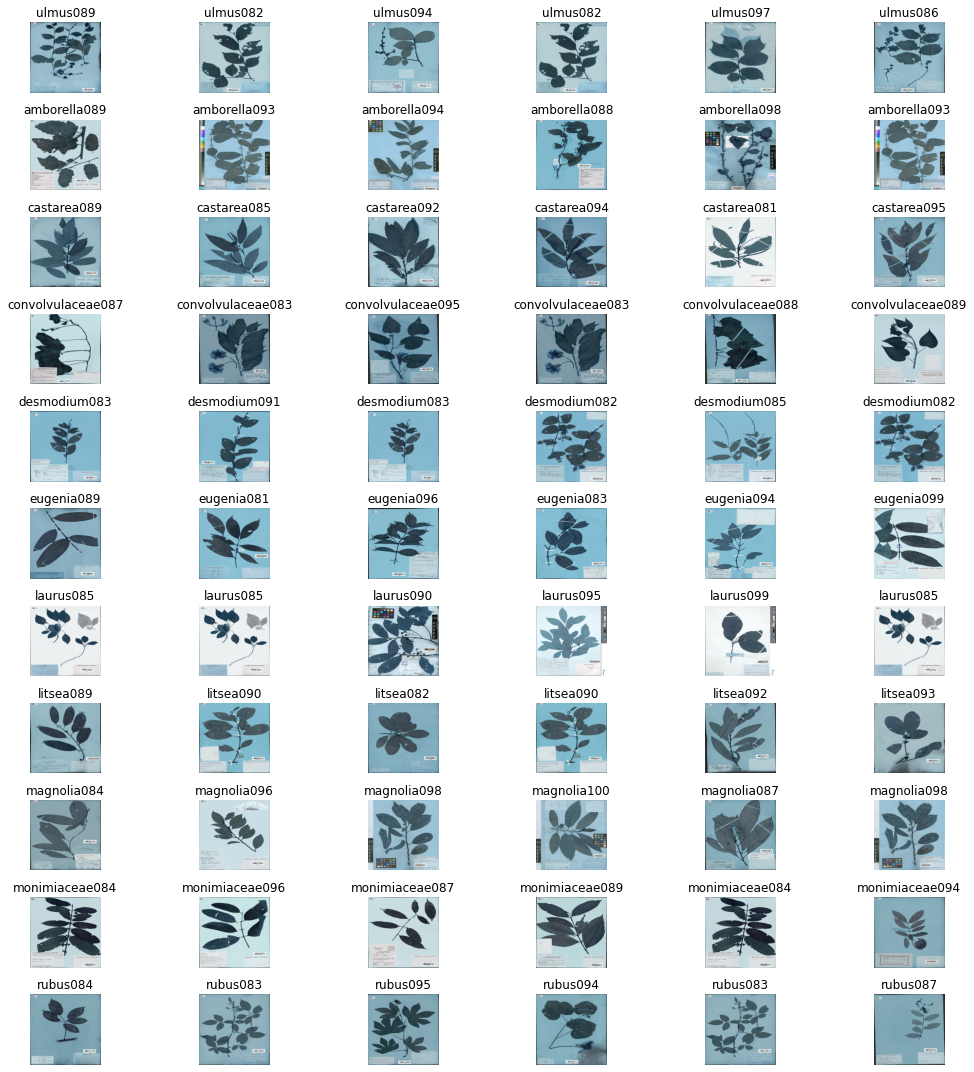

In [10]:
lsPathsImage = []

numbSample = 6 # We set the number of images we want to show per category

# Loop through each category
for curKey in dictTrainDir:
    lsFiles = random.choices(os.listdir(dictTrainDir[curKey]), k=numbSample)
    lsPaths = list(map(lambda fileName : os.path.join(dictTrainDir[curKey], fileName), lsFiles))
    lsPathsImage.append(lsPaths)


# Set the Figures and Axes
fig, axes = plt.subplots(nrows=len(lsPathsImage), ncols=numbSample, figsize=(15,15))
fig.set_facecolor('white')

# Original
for row in range(len(lsPathsImage)):
    for col in range(numbSample):
        imagePath = lsPathsImage[row-1][col-1]
        imageTitle = imagePath.split('\\')[-1].split('.')[0]
        curImage = cv2.imread(imagePath)
        
        axes[(row, col)].imshow(curImage)
        axes[(row, col)].set_title(imageTitle) 
        axes[(row, col)].axis('off')

# Thight the Layout
plt.tight_layout()

# Display the Figure
plt.show()

##### Build the Dataframe with the Species and their corresponding Attribute 

In [11]:
# Définir les Informations connu d'après les 4 caractères descriptifs des 11 taxons
# Devrions-nous faire une transformation binaire?
# Bord : { Lisse = 0 / Denté = 1 }
# Phyllotaxie : { Opposé = 0 / Alterné = 1 }
# Type Feuille : { Simple = 0 / Composée = 1 }
# Ligneux : { Non = 0 / Oui = 1 }

def makeBinaryHerbarium(lsHerbarium):
    lsHerbarium[0] = 0 if (lsHerbarium[0]=='lisse') else 1
    lsHerbarium[1] = 0 if (lsHerbarium[1]=='opposé') else 1
    lsHerbarium[2] = 0 if (lsHerbarium[2]=='simple') else 1
    lsHerbarium[3] = 0 if (lsHerbarium[3]=='non') else 1
    return lsHerbarium

Herbarium = dict({
    'amborella': ['lisse', 'alterné', 'simple', 'oui'],
    'castanea': ['denté', 'alterné', 'simple', 'oui'],
    'desmodium': ['lisse', 'alterné', 'composée', 'non'],
    'eugenia': ['lisse', 'opposé', 'simple', 'oui'],
    'laurus': ['lisse', 'opposé', 'simple', 'oui'],
    'litsea': ['lisse', 'alterné', 'simple', 'oui'],
    'magnolia': ['lisse', 'alterné', 'simple', 'oui'],
    'rubus': ['denté', 'alterné', 'composée', 'oui'],
    'ulmus': ['denté', 'alterné', 'simple', 'oui'],
    'monimiaceae': ['lisse', 'opposé', 'simple', 'oui'],
    'convolvulaceae': ['lisse', 'alterné', 'simple', 'non']
})

binaryHerbarium = {herb: makeBinaryHerbarium(Herbarium[herb].copy()) for herb in Herbarium.keys()}

In [12]:
def getFilesPath(dirPath):
    lsPathFiles = []
    for dir_, _, files in os.walk(dirPath):
        for file_name in files:
            lsPathFiles.append(re.search(rf'{dirPath.name}.*', (initDatasetPath / dir_ / file_name).__str__()).group())
    return lsPathFiles

def makeDataFrame(dirPath, savePath):
    lsPathImages, lsHerbarium = getFilesPath(dirPath), [] 
    
    # Append Information about the Images and the attributes to the corresponding Species
    for pathImage in lsPathImages:  # Loop through each Images
        typeImage = pathImage.split('\\')[-3]
        shapeImage = cv2.imread(((dirPath.parent / pathImage).__str__())).shape
        sizeImage = np.product(shapeImage)
        nameHerbarium = pathImage.split('\\')[-2]  
        lsHerbarium.append([pathImage, typeImage, shapeImage, sizeImage, nameHerbarium] + Herbarium[nameHerbarium] + binaryHerbarium[nameHerbarium])
    
    # Build the Dataframe and divide it as Test and Train   
    dfImageHerbarium = pd.DataFrame (lsHerbarium, columns = ['ImagePath', 'Type', 'ImageShape', 'ImageSize', 'Herbarium', 'Bord', 'Phyllotaxie', 'TypeFeuille', 'Ligneux', 'binaryBord', 'binaryPhyllotaxie', 'binaryTypeFeuille', 'binaryLigneux'])
    dfImageHerbariumTest = dfImageHerbarium[dfImageHerbarium['Type'] == 'Test']
    dfImageHerbariumTrain = dfImageHerbarium[dfImageHerbarium['Type'] == 'Train']
    
    # Split and Save into two SubDatasets (Test and Train)
    filenameTrain, filenameTest = 'transformedTrainDataset.csv', 'transformedTestDataset.csv'
    dfImageHerbariumTrain.to_csv(path_or_buf=(savePath / filenameTrain), index = 0)
    dfImageHerbariumTest.to_csv(path_or_buf=(savePath / filenameTest), index = 0)
    
    print('Dataframe Succesfully Created')
    print(f'Train Dataframe Path -> {re.search(rf"{savePath.name}.*", (savePath / filenameTrain).__str__()).group()} ')
    print(f'Test Dataframe Path -> {re.search(rf"{savePath.name}.*", (savePath / filenameTest).__str__()).group()} ')

In [13]:
makeDataFrame(modifDatasetPath, dataPath)

Dataframe Succesfully Created
Train Dataframe Path -> Data\transformedTrainDataset.csv 
Test Dataframe Path -> Data\transformedTestDataset.csv 


---

#### Deep Learning Models

##### Model of Object Detection for the Species Attributes 

In this **Section**, we want to realize a object recognition from different vegetal species. The purpose is to use the *Train* and *Test* data to build a model that allow the object recognition and in our case the detection of vegetal attributes.

An attribute represents a descriptive character of vegetal. For instance an attribute of the *magnolia* can be the arrangement of its leaves that are alternate. 

##### Step 1: Load the Transformed **Dataframe** of **Train** and **Test**

Ces jeux de données ont été construit avec le notebook **InitializationDataHerbarium** avec l'attribution des caractèristiques aux végétaux.

In [14]:
testFilename, trainFilename = 'transformedTrainDataset.csv', 'transformedTrainDataset.csv'

if testFilename in os.listdir(dataPath):
    dfTest = pd.read_csv(filepath_or_buffer=(dataPath / testFilename))
    print('Test Dataframe -> Successfully Loaded')
else:
    print('Test Dataframe -> Unsuccessfully Loaded | Modify the Path or Reexecute the current Notebook')

if trainFilename in os.listdir(dataPath):
    dfTrain = pd.read_csv(filepath_or_buffer=(dataPath / trainFilename))
    print('Train Dataframe -> Successfully Loaded')
else:
    print('Test Dataframe -> Unsuccessfully Loaded | Modify the Path or Reexecute the current Notebook')

Test Dataframe -> Successfully Loaded
Train Dataframe -> Successfully Loaded


##### Step 2: Construct the Generator for each Attribute

In [15]:

def constructGeneratorfromDataframe(generator, df, colsFeature, targetSize, batchSize):
    return generator.flow_from_dataframe(df, x_col=colsFeature[0], y_col=colsFeature[1], target_size=targetSize, batch_size=batchSize, class_mode="sparse")

In [16]:
# All images will be rescaled by 1./255
trainGenerator = ImageDataGenerator(rescale=1./255)
testGenerator = ImageDataGenerator(rescale=1./255)

inputShape = (512, 512, 3)
target_size = inputShape[:2]
batch_size = 32

dfTrain['ImageAbsolutePath'] = (dataPath / dfTrain['ImagePath']) # Get Absolute Path
dfTrain['ImageAbsolutePath'] = dfTrain['ImageAbsolutePath'].astype(str)  # Get Absolute Path
dfTest['ImageAbsolutePath'] = (dataPath / dfTest['ImagePath']) # Get Absolute Path
dfTest['ImageAbsolutePath'] = dfTest['ImageAbsolutePath'].astype(str)  # Get Absolute Path


print('Train Generator:')
trainGeneratorBord = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Bord'], target_size, batch_size)
trainGeneratorPhyllotaxie = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Phyllotaxie'], target_size, batch_size)
trainGeneratorTypeFeuille = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'TypeFeuille'], target_size, batch_size)
trainGeneratorLigneux = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Ligneux'], target_size, batch_size)

print('\nTest Generator:')
testGeneratorBord = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Bord'], target_size, batch_size)
testGeneratorPhyllotaxie = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Phyllotaxie'], target_size, batch_size)
testGeneratorTypeFeuille = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'TypeFeuille'], target_size, batch_size)
testGeneratorLigneux = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Ligneux'], target_size, batch_size)


Train Generator:
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.

Test Generator:
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.


##### Step 3: Construct the Model

In [51]:
def makeModel_ObjectRecognition(inputShape, outputSize, outputActivationFunction, choiceOptimizer, choiceLoss, choiceMetrics):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=inputShape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(outputSize, activation = outputActivationFunction))  # Tester Softmax
    model.compile(optimizer=choiceOptimizer, loss=choiceLoss, metrics=choiceMetrics)
    return model

In [52]:
outputActivationFunction = 'sigmoid'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']

outputSize = len(trainGeneratorBord.class_indices)
modelBord = makeModel_ObjectRecognition(inputShape, len(trainGeneratorBord.class_indices), outputActivationFunction, optimizer, loss, metrics)

In [53]:
epochs = 30
modelBord.fit(trainGeneratorBord, epochs=epochs, validation_data=testGeneratorBord, verbose=2)  # Probable Overfitting (Try Data Augmentation)

Epoch 1/30
7/7 - 5s - loss: 3.0608 - accuracy: 0.6273 - val_loss: 0.6002 - val_accuracy: 0.7273
Epoch 2/30
7/7 - 3s - loss: 0.6275 - accuracy: 0.7273 - val_loss: 0.5752 - val_accuracy: 0.7273
Epoch 3/30
7/7 - 3s - loss: 0.5859 - accuracy: 0.7273 - val_loss: 0.6374 - val_accuracy: 0.7273
Epoch 4/30
7/7 - 3s - loss: 0.5909 - accuracy: 0.7273 - val_loss: 0.5776 - val_accuracy: 0.7273
Epoch 5/30
7/7 - 3s - loss: 0.6189 - accuracy: 0.7273 - val_loss: 0.5879 - val_accuracy: 0.7273
Epoch 6/30
7/7 - 3s - loss: 0.5669 - accuracy: 0.7273 - val_loss: 0.5131 - val_accuracy: 0.7273
Epoch 7/30
7/7 - 3s - loss: 0.5267 - accuracy: 0.7273 - val_loss: 0.4811 - val_accuracy: 0.7273
Epoch 8/30
7/7 - 3s - loss: 0.4858 - accuracy: 0.7273 - val_loss: 0.4557 - val_accuracy: 0.7273
Epoch 9/30
7/7 - 3s - loss: 0.4193 - accuracy: 0.7273 - val_loss: 0.3822 - val_accuracy: 0.7273
Epoch 10/30
7/7 - 3s - loss: 0.3872 - accuracy: 0.8136 - val_loss: 0.3619 - val_accuracy: 0.8318
Epoch 11/30
7/7 - 3s - loss: 0.3646 - a

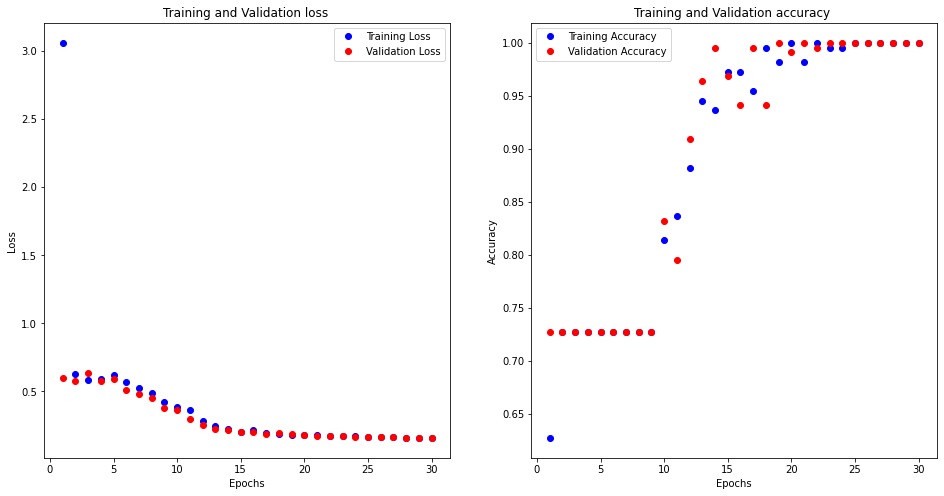

In [54]:
history_dict = modelBord.history.history 
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.rcParams['figure.figsize'] = (16,8) # Make the figures a bit bigger
fig,(ax1,ax2,) = plt.subplots(1,2)

x = range(1,epochs+1)
ax1.plot(x,loss_values,'bo',label='Training Loss')
ax1.plot(x,val_loss_values,'ro',label='Validation Loss')
ax1.set_title('Training and Validation loss ')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(x,acc_values,'bo',label='Training Accuracy')
ax2.plot(x,val_acc_values,'ro',label='Validation Accuracy')
ax2.set_title('Training and Validation accuracy ')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()